# Используемые библиотеки

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd

from geopy.distance import distance
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [6]:
def corelate_df(df, minimal):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.4)

    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) <= minimal] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()

In [7]:
def maximize_pred(predictions):
    for j in range(len(predictions)):
        if predictions[j] > 500000:
            predictions[j] = 500001
    return predictions

# Загрузка данных

In [8]:
df = pd.read_csv('data\data_set_to_train.csv')

X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]
X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

X_final = pd.read_csv('data\data_set_to_test_X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 13828
Строк в тесте 6812


In [9]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [10]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float32 
 1   latitude            13828 non-null  float32 
 2   housing_median_age  13349 non-null  float32 
 3   total_rooms         13828 non-null  float32 
 4   total_bedrooms      13828 non-null  float32 
 5   population          13429 non-null  float32 
 6   households          13828 non-null  float32 
 7   median_income       13828 non-null  float32 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float32(8)
memory usage: 553.9 KB


## Переменные

In [17]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


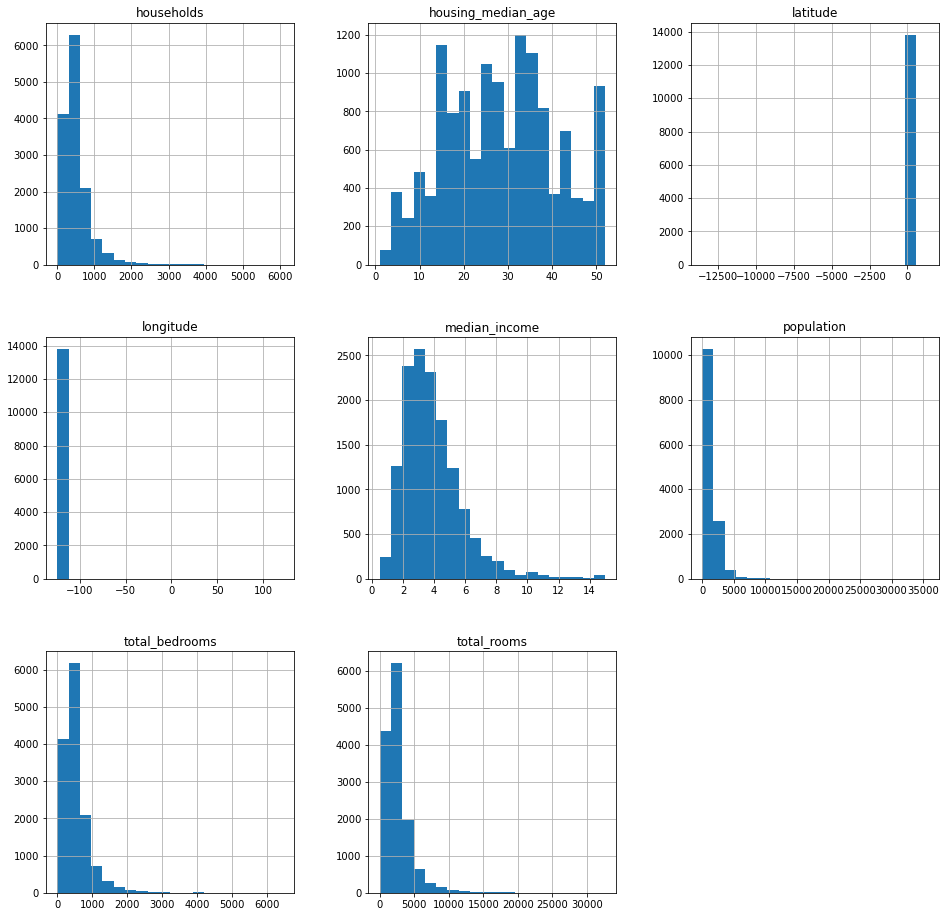

In [18]:
X.hist(figsize=(16,16), bins=20);

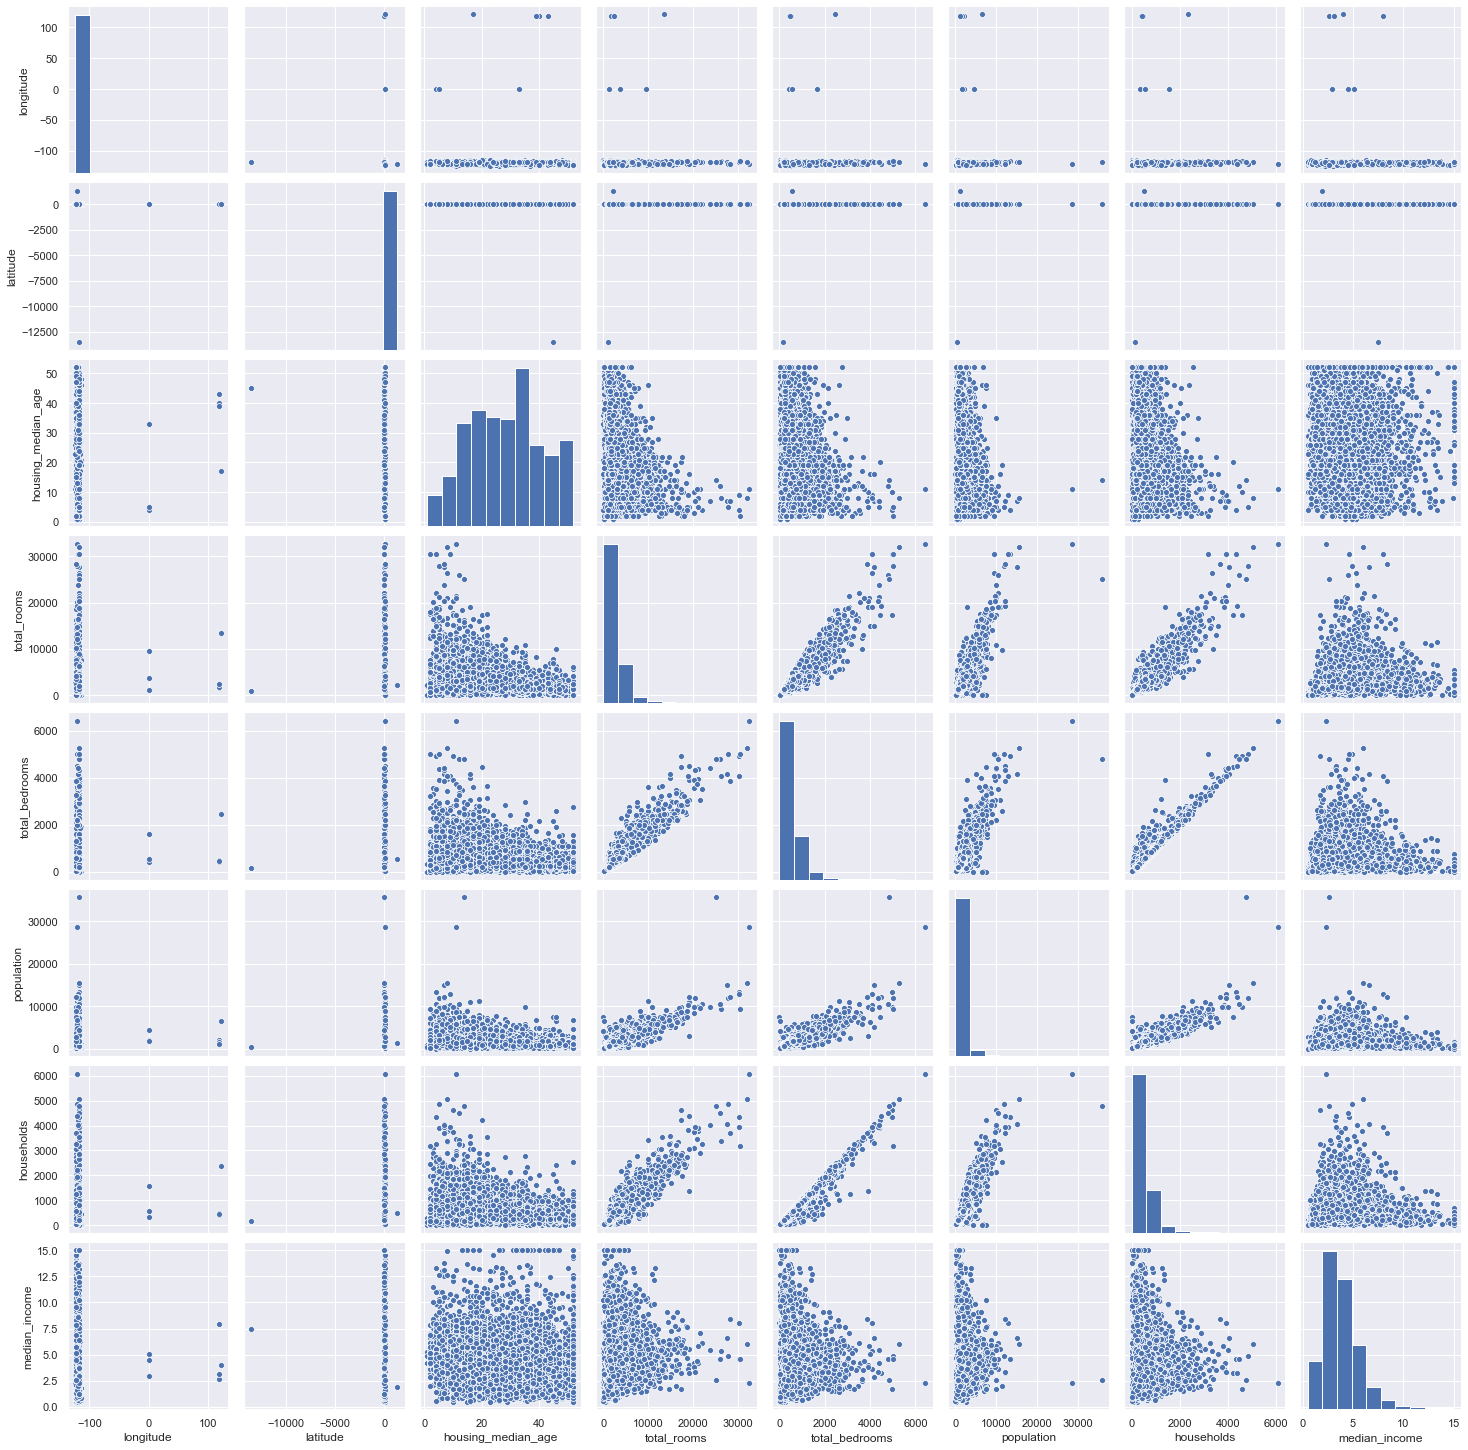

In [36]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

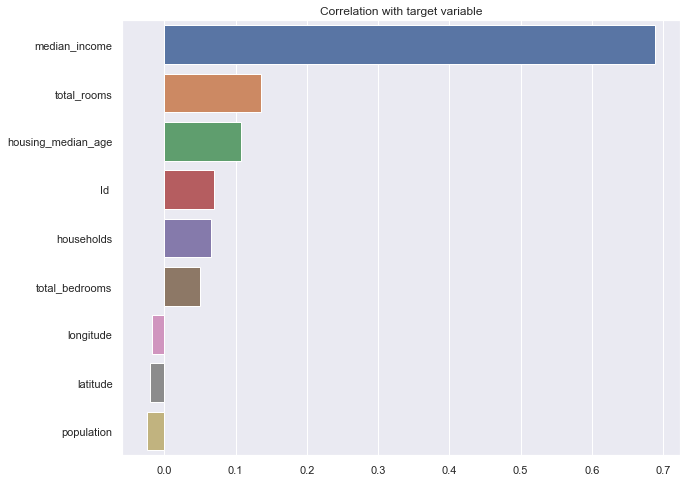

In [37]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [38]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

# Исправляем и дополняем

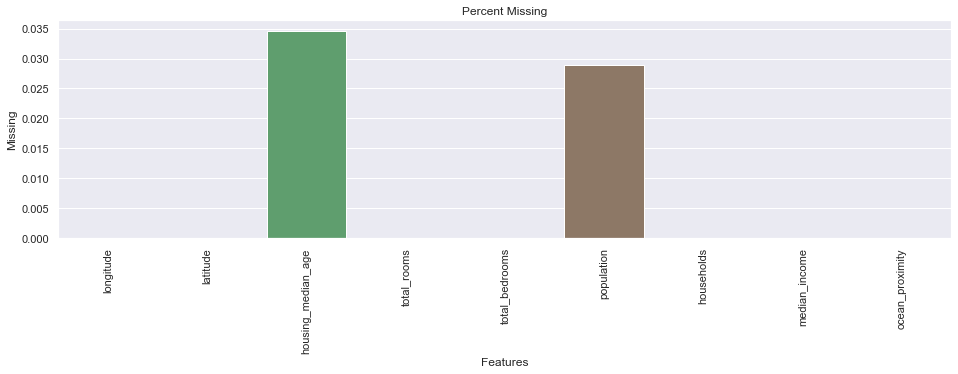

In [39]:
nan_analize(X)

In [12]:
X['median_age_changed'] = 0
X_final['median_age_changed'] = 0

X.loc[X.isna()['housing_median_age'] == True, 'median_age_changed'] = 1
X_final.loc[X_final.isna()['housing_median_age'] == True, 'median_age_changed'] = 1

median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
median = X_final['housing_median_age'].median()
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [13]:
X['population_changed'] = 0
X_final['population_changed'] = 0

X.loc[X.isna()['population'] == True, 'population_changed'] = 1
X_final.loc[X_final.isna()['population'] == True, 'population_changed'] = 1

median = X['population'].median()
X['population'] = X['population'].fillna(median)
median = X_final['population'].median()
X_final['population'] = X_final['population'].fillna(median)

In [14]:
median = X['total_bedrooms'].median()
X['total_bedrooms'] = X['total_bedrooms'].fillna(median)
median = X_final['total_bedrooms'].median()
X_final['total_bedrooms'] = X_final['total_bedrooms'].fillna(median)

In [15]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [16]:
X.loc[8283, 'latitude'] = 33.700000
X.loc[12772, 'latitude'] = 40.600000

X.loc[19423, 'longitude'] = -121.600000
X.loc[17085, 'longitude'] = -121.900000
X.loc[17359, 'longitude'] = -118.500000

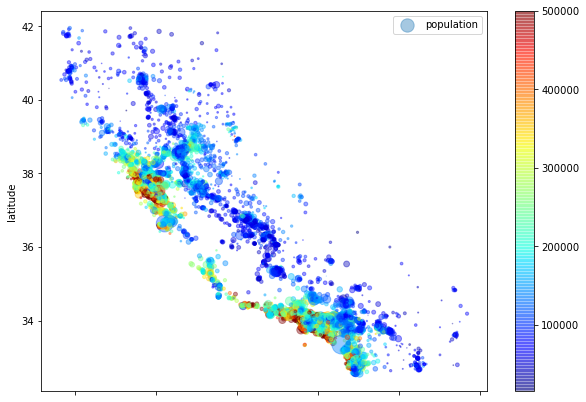

In [17]:
X.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X['population']/100, label='population', figsize=(10,7), 
    c=y['median_house_value'], cmap=plt.get_cmap('jet'), colorbar=True)

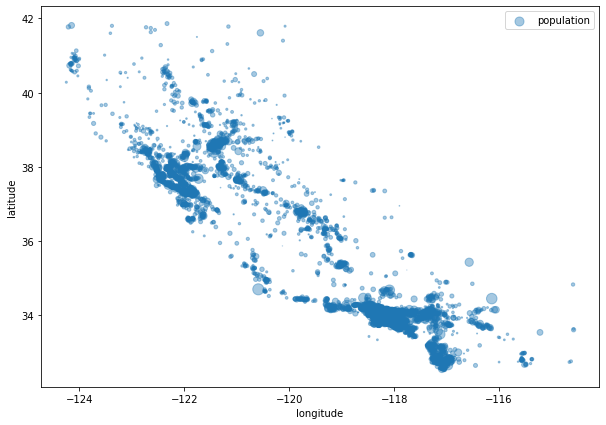

In [18]:
X_final.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X_final['population']/100, label='population', figsize=(10,7))

In [19]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [20]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [21]:
X['room_per_household'] = X['total_rooms'] / X['households']
X_final['room_per_household'] = X_final['total_rooms'] / X_final['households']

In [22]:
X['total_income'] = X['households'] * X['median_income']
X_final['total_income'] = X_final['households'] * X_final['median_income']

In [23]:
X['bedroom_per_room'] = X['total_bedrooms'] / X['total_rooms']
X_final['bedroom_per_room'] = X_final['total_bedrooms'] / X_final['total_rooms']

In [24]:
X['income_category'] = np.ceil(X['median_income'])
X_final['income_category'] = np.ceil(X_final['median_income'])

In [25]:
for i in range(1, 17):
    print(i, len(X.loc[X['income_category'] == i]), len(X_final.loc[X_final['income_category'] == i]))

1 104 55
2 1544 754
3 3290 1656
4 3439 1711
5 2433 1165
6 1436 691
7 772 391
8 348 161
9 194 89
10 67 32
11 99 51
12 24 21
13 21 13
14 14 8
15 6 2
16 37 12


In [26]:
X.loc[X['income_category'] == 2, 'income_category'] = 1
X.loc[X['income_category'] == 3, 'income_category'] = 2
X.loc[X['income_category'] == 4, 'income_category'] = 3
X.loc[X['income_category'] == 5, 'income_category'] = 4
X.loc[X['income_category'] == 6, 'income_category'] = 5
X.loc[X['income_category'] == 7, 'income_category'] = 6
X.loc[X['income_category'] == 8, 'income_category'] = 6
X.loc[X['income_category'] > 8, 'income_category'] = 7

X_final.loc[X_final['income_category'] == 2, 'income_category'] = 1
X_final.loc[X_final['income_category'] == 3, 'income_category'] = 2
X_final.loc[X_final['income_category'] == 4, 'income_category'] = 3
X_final.loc[X_final['income_category'] == 5, 'income_category'] = 4
X_final.loc[X_final['income_category'] == 6, 'income_category'] = 5
X_final.loc[X_final['income_category'] == 7, 'income_category'] = 6
X_final.loc[X_final['income_category'] == 8, 'income_category'] = 6
X_final.loc[X_final['income_category'] > 8, 'income_category'] = 7

In [27]:
LA_coords = (34.055855, -118.246130)
SF_coords = (37.759351, -122.446904)

X['distance_to_LA'] = X.apply(lambda row: distance((row['latitude'], row['longitude']), LA_coords).km, axis = 1)
X['distance_to_SF'] = X.apply(lambda row: distance((row['latitude'], row['longitude']), SF_coords).km, axis = 1)
X_final['distance_to_LA'] = X_final.apply(lambda row: distance((row['latitude'], row['longitude']), LA_coords).km, axis = 1)
X_final['distance_to_SF'] = X_final.apply(lambda row: distance((row['latitude'], row['longitude']), SF_coords).km, axis = 1)

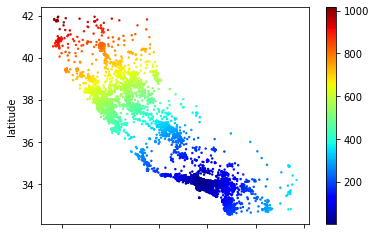

In [28]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance_to_LA'], cmap=plt.get_cmap('jet'), colorbar=True)

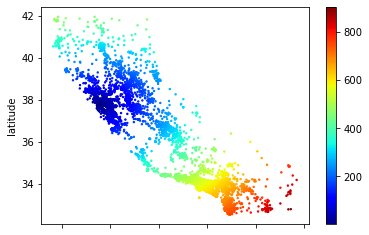

In [29]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance_to_SF'], cmap=plt.get_cmap('jet'), colorbar=True)

In [30]:
X['distance'] = X.apply(lambda row: min(row['distance_to_LA'], row['distance_to_SF']), axis = 1)
X_final['distance'] = X_final.apply(lambda row: min(row['distance_to_LA'], row['distance_to_SF']), axis = 1)

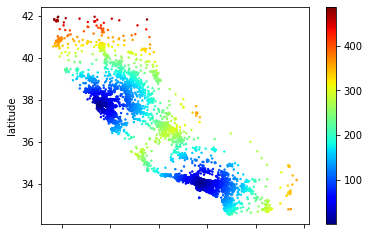

In [31]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance'], cmap=plt.get_cmap('jet'), colorbar=True)

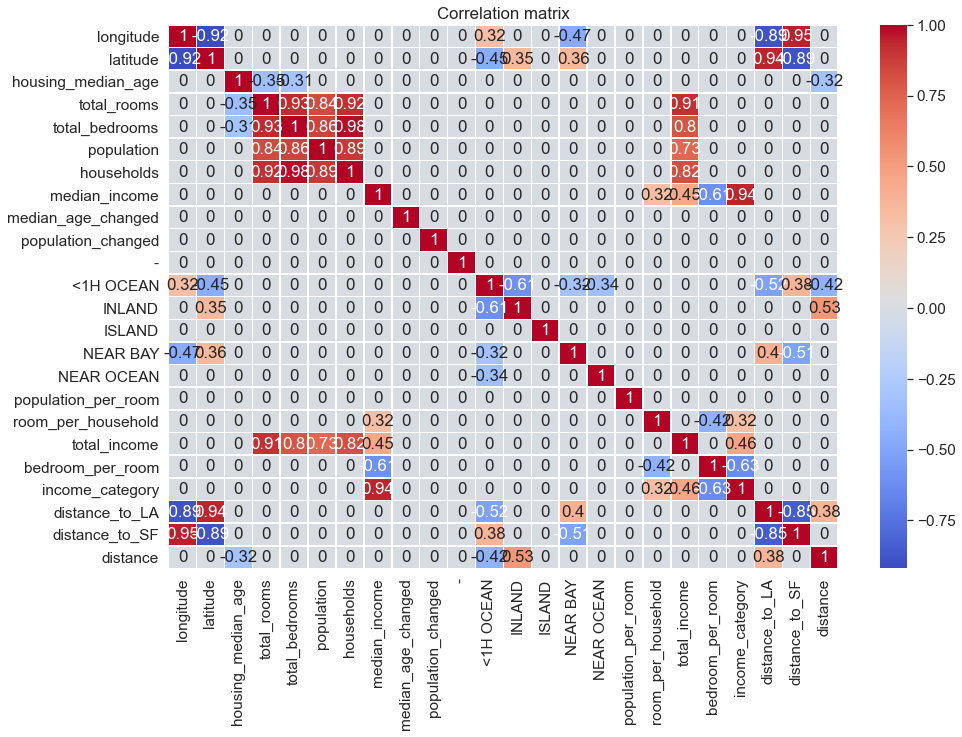

In [33]:
corelate_df(X, 0.3)

In [34]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category,distance_to_LA,distance_to_SF,distance
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,...,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.584946,35.651432,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735,0.034640,0.028854,...,0.112236,0.123084,0.637027,5.436546,1952.576416,0.213001,3.283989,270.622398,384.751644,90.346886
std,2.005138,2.134328,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102,0.182873,0.167404,...,0.315668,0.328545,3.532465,2.449446,1906.061523,0.058328,1.577628,247.857967,249.439013,84.739860
min,-124.349998,32.549999,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.019218,0.888889,1.608000,0.100000,1.000000,0.582399,0.281856,0.281856
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575,0.000000,0.000000,...,0.000000,0.000000,0.433649,4.459802,870.871826,0.175255,2.000000,32.499996,117.800862,23.297638
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750,0.000000,0.000000,...,0.000000,0.000000,0.516548,5.232422,1463.781006,0.202996,3.000000,174.266151,524.540595,58.552606
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600,0.000000,0.000000,...,0.000000,0.000000,0.658146,6.058565,2403.553894,0.239353,4.000000,527.689949,583.654328,140.459741
max,-114.309998,41.950001,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,392.631592,141.909088,31501.853516,1.000000,7.000000,1017.076091,904.326593,487.301412


In [35]:
X_final.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category,distance_to_LA,distance_to_SF,distance
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,...,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000
mean,-119.538300,35.592514,28.830446,2611.800293,529.727661,1406.821045,495.204193,3.858350,0.035672,0.029360,...,0.108045,0.139900,0.604593,5.413654,1923.620850,0.215302,3.270258,266.246557,391.436266,90.792594
std,2.000073,2.139396,12.337366,2201.645996,415.576874,1091.458130,379.648621,1.893224,0.185486,0.168826,...,0.310460,0.346909,0.571533,2.523734,1893.785400,0.076911,1.577052,246.221758,249.916316,84.447670
min,-124.250000,32.540001,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.018109,0.846154,2.999400,0.036724,1.000000,0.729411,0.281856,0.281856
25%,-121.760002,33.919998,19.000000,1434.000000,298.000000,786.750000,279.000000,2.550775,0.000000,0.000000,...,0.000000,0.000000,0.435523,4.409941,850.110611,0.175096,2.000000,31.862876,122.155800,23.396660
50%,-118.480003,34.230000,29.000000,2106.000000,430.000000,1157.000000,406.000000,3.527800,0.000000,0.000000,...,0.000000,0.000000,0.515201,5.224030,1453.958069,0.203509,3.000000,173.351455,528.974482,58.598775
75%,-117.989998,37.709999,37.000000,3109.250000,631.000000,1689.000000,598.000000,4.733225,0.000000,0.000000,...,0.000000,0.000000,0.660210,6.040538,2352.117737,0.241587,4.000000,522.835072,585.590713,142.858542
max,-114.580002,41.860001,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,32.138889,132.533340,38890.000000,2.792208,7.000000,1004.438135,901.425244,491.267771


In [36]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_age_changed', 'population_changed', '-',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN',
       'population_per_room', 'room_per_household', 'total_income',
       'bedroom_per_room', 'income_category', 'distance_to_LA',
       'distance_to_SF', 'distance'],
      dtype='object')

# Проверяем модель

In [37]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'median_income', 'population_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'total_rooms', 'households', 'population_changed', 'income_category', 'distance_to_LA', 'distance_to_SF', 'distance']

X1 = X[remain_features]
X1_final = X_final[remain_features]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

In [39]:
model = LGBMRegressor(max_depth=13, n_estimators=430, num_leaves=30, random_state=42)

model.fit(X_train, y_train)

LGBMRegressor(max_depth=13, n_estimators=430, num_leaves=30, random_state=42)

In [40]:
y_pred_test = model.predict(X_test)
y_pred_test = maximize_pred(y_pred_test)

R2:	0.83599
RMSE:	46549.444
MSE:	2166850691.322


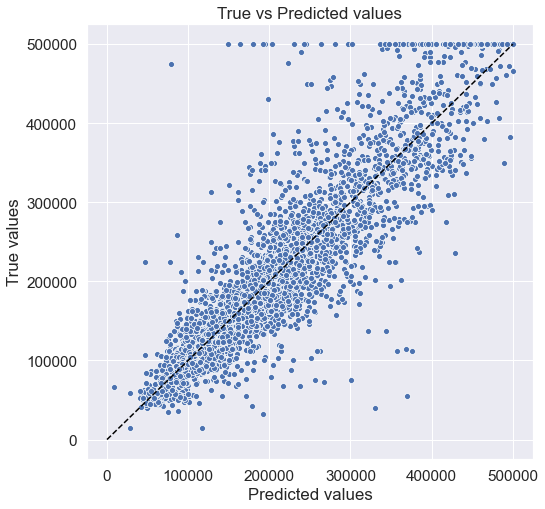

In [41]:
evaluate_preds(y_test['median_house_value'], y_pred_test)

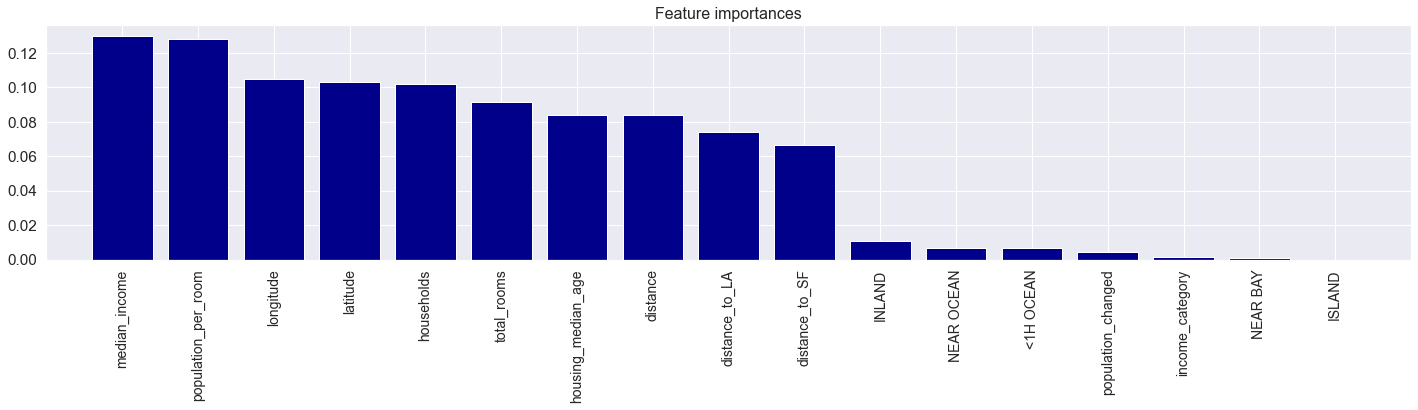

In [42]:
plot_feature_importances(importances = model.feature_importances_, X=X1)

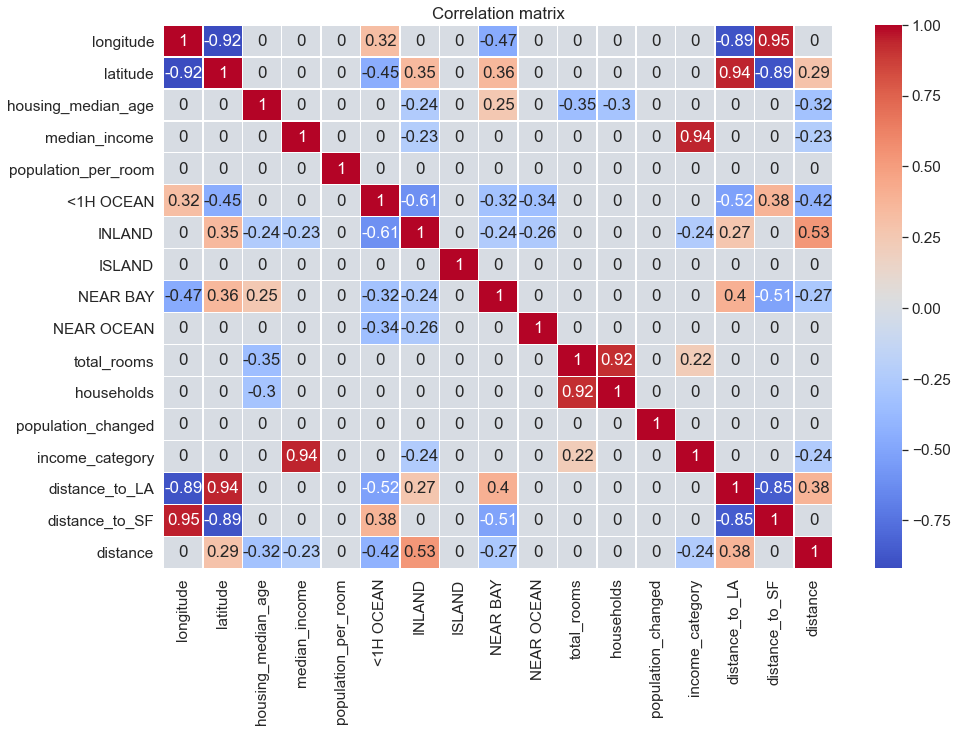

In [43]:
corelate_df(X1, 0.2)

In [ ]:
base_features = [
 'longitude',
 'latitude',
 'housing_median_age',
 'median_income',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

add_features = [
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_age_changed',
 'population_changed',
 'room_per_household',
 'bedroom_per_room',
 'income_category',
 'distance_to_LA',
 'distance_to_SF',
 'distance']

maximum = 0
maxb = ''

len_add = len(add_features)
count = 0
summary = 2**len_add

for b in range(2**len_add):
    binb = str(bin(b))[2:]
    binb = (len_add  - len(binb))*'0' + binb
    
    perm_features = base_features + list(add_features[i] for i in range(len_add) if binb[i] == '1')

    X1 = X[perm_features]
    X1_final = X_final[perm_features]

    model = LGBMRegressor(max_depth=15, n_estimators=295, num_leaves=30, random_state=42)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_test = maximize_pred(y_pred_test)

    score = r2(y_test['median_house_value'], y_pred_test)
    count += 1
    print(f"\nb: {binb}    score: {round(score, 4)}    {round(count * 100 / summary, 2)} %", end="   ")
    if score > maximum:
        if maximum != 0:
            print(f"maximum: {round(score, 4)}", end="   ")
        maximum = score
        maxb = binb
print("")
print("Results:")
print(f"binb: {maxb}")
print(f"score: {maximum}")

base_features + list(add_features[i] for i in range(len_add) if maxb[i] == '1')

In [ ]:
maximum = 0
maxi = 0
maxk = 0
maxm = 0
summary = len(range(11, 16, 1)) * len(range(290, 451, 5)) * len(range(29, 33, 1))
count = 0

for i in range(11, 16, 1):
    for k in range(290, 451, 5):
        for m in range(29, 33, 1):
            model = LGBMRegressor(max_depth=i, n_estimators=k, num_leaves=m, random_state=42)
            model.fit(X_train, y_train)

            y_pred_test = model.predict(X_test)
            y_pred_test = maximize_pred(y_pred_test)

            score = r2(y_test['median_house_value'], y_pred_test)
            count += 1
            print(f"\ni: {i}   k: {k}   m: {m}   score: {round(score, 4)}    {round(count * 100 / summary, 2)} %", end="   ")
            if score > maximum:
                if maximum != 0:
                    print(f"maximum: {round(score, 4)}", end="   ")
                maximum = score
                maxi = i
                maxk = k
                maxm = m
print("")
print("Results:")
print(f"model = LGBMRegressor(max_depth={maxi}, n_estimators={maxk}, num_leaves={maxm}, random_state=42)")
print(f"score: {maximum}")

## Учим финальную модель

In [44]:
model.fit(X1, y)

LGBMRegressor(max_depth=13, n_estimators=430, num_leaves=30, random_state=42)

In [45]:
y_pred = model.predict(X1_final)
y_pred = maximize_pred(y_pred)

In [47]:
y_pred_df = pd.DataFrame(y_pred, columns=['median_house_value'])

In [48]:
y_pred_df

,median_house_value
0,40374.000036
1,68989.865974
2,500001.000000
3,319522.565687
4,285880.606955
...,...
6807,180055.643072
6808,121085.984337
6809,127071.811875
6810,128108.207699


In [49]:
y_pred_df['median_house_value'].median()

185024.6669859169

In [50]:
filename = '201128_Reznik_4.csv'
y_pred_df.to_csv(filename, index=None)